## 파이토치로 다층 퍼셉트론 구현하기

In [33]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/Hyelim-Shin/AIdev/master/Images/9-2.DNN.png', width=500)

In [34]:
import torch
import torch.nn as nn

In [35]:
torch.cuda.is_available()

True

In [36]:
# GPU 연산이 가능하다면 GPU를 사용하고, 불가능하다면 CPU를 사용
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

### 1) 다층 퍼셉트론을 이용한 XOR 문제 풀기

In [37]:
X = torch.FloatTensor([[0,0],[0,1],[1,0],[1,1]]).to(device)
Y = torch.FloatTensor([[0],[1],[1],[0]]).to(device)

In [38]:
Image(url='https://raw.githubusercontent.com/Hyelim-Shin/AIdev/master/Images/11-1.DNN.png', width=500)

In [39]:
model = nn.Sequential(
    nn.Linear(2, 10, bias=True), # input_layer = 2, hidden_layer1 = 10
    nn.Sigmoid(),
    nn.Linear(10, 10, bias=True), # hidden_layer1 = 10, hidden_layer2 = 10
    nn.Sigmoid(),
    nn.Linear(10, 10, bias=True), # hidden_layer2 = 10, hidden_layer3 = 10
    nn.Sigmoid(),
    nn.Linear(10, 1, bias=True), # hidden_layer3 = 10, output_layer = 1
    nn.Sigmoid()
).to(device)

In [40]:
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [41]:
for epoch in range(10001):
    optimizer.zero_grad()
    hypothesis = model(X)

    # 비용 함수 계산 및 역전파
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    # 100 epoch마다 loss 출력
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/10000 Cost: {cost.item():.6f}')

Epoch 0/10000 Cost: 0.694898
Epoch 100/10000 Cost: 0.693156
Epoch 200/10000 Cost: 0.693154
Epoch 300/10000 Cost: 0.693151
Epoch 400/10000 Cost: 0.693149
Epoch 500/10000 Cost: 0.693147
Epoch 600/10000 Cost: 0.693145
Epoch 700/10000 Cost: 0.693143
Epoch 800/10000 Cost: 0.693142
Epoch 900/10000 Cost: 0.693140
Epoch 1000/10000 Cost: 0.693138
Epoch 1100/10000 Cost: 0.693136
Epoch 1200/10000 Cost: 0.693134
Epoch 1300/10000 Cost: 0.693132
Epoch 1400/10000 Cost: 0.693130
Epoch 1500/10000 Cost: 0.693128
Epoch 1600/10000 Cost: 0.693126
Epoch 1700/10000 Cost: 0.693124
Epoch 1800/10000 Cost: 0.693122
Epoch 1900/10000 Cost: 0.693120
Epoch 2000/10000 Cost: 0.693117
Epoch 2100/10000 Cost: 0.693115
Epoch 2200/10000 Cost: 0.693112
Epoch 2300/10000 Cost: 0.693109
Epoch 2400/10000 Cost: 0.693105
Epoch 2500/10000 Cost: 0.693101
Epoch 2600/10000 Cost: 0.693097
Epoch 2700/10000 Cost: 0.693093
Epoch 2800/10000 Cost: 0.693088
Epoch 2900/10000 Cost: 0.693083
Epoch 3000/10000 Cost: 0.693076
Epoch 3100/10000 Cos

In [42]:
X

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]], device='cuda:0')

In [43]:
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('모델의 출력값(Hypothesis): \n', hypothesis.detach().cpu().numpy())
    print('모델의 예측값(Predicted): \n', predicted.detach().cpu().numpy())
    print('실제값(Y): \n', Y.cpu().numpy())
    print('정확도(Accuracy): \n', accuracy.item())


모델의 출력값(Hypothesis): 
 [[1.1170164e-04]
 [9.9982882e-01]
 [9.9984229e-01]
 [1.8532644e-04]]
모델의 예측값(Predicted): 
 [[0.]
 [1.]
 [1.]
 [0.]]
실제값(Y): 
 [[0.]
 [1.]
 [1.]
 [0.]]
정확도(Accuracy): 
 1.0


* ```with torch.no_grad()```: 기울기 계산을 비활성화 하여 연산 속도 증가 및 메모리 사용량 감소
* ```.detach()```: 계산 그래프에서 분리
* ```.cpu()```: cpu로 보냄 (= ```.to('cpu')```)

### 2) 다층 퍼셉트론으로 MNIST 분류하기

#### MNIST 데이터

* MNIST: 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋
    - 6만개의 훈련 데이터와 레이블, 1만개의 테스트 데이터와 레이블로 구성
    - 레이블: 0 부터 9 (10개)

In [44]:
Image(url='https://raw.githubusercontent.com/Hyelim-Shin/AIdev/master/Images/11-1.mnist.png', width=500)

In [45]:
# 각각의 이미지는 28x28 크기의 픽셀
Image(url='https://raw.githubusercontent.com/Hyelim-Shin/AIdev/master/Images/11-1.mnist_input.png', width=500)

In [46]:
# 다층 퍼셉트론의 input으로 사용하기 위해 28x28 크기의 2차원 배열을 784 크기의 1차원 배열로 변환
Image(url='https://raw.githubusercontent.com/Hyelim-Shin/AIdev/master/Images/11-1.mnist_input.png', width=500)

## 코드 참고
# for X, Y in data_loader:
#     X = X.view(-1, 28*28))

#### MNIST 분류기 구현

##### i) 사전 설정 

In [47]:
import torch
import random 

In [48]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)


다음 기기로 학습합니다: cuda


In [49]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

##### ii) MNIST 데이터 로드

--------------------
**DataLoader**

In [50]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

TensorDataset은 기본적으로 텐서를 입력으로 받음. 텐서 형태로 데이터 정의.

In [51]:
x_train  =  torch.FloatTensor([[73,  80,  75], 
                               [93,  88,  93], 
                               [89,  91,  90], 
                               [96,  98,  100],   
                               [73,  66,  70]])  
y_train  =  torch.FloatTensor([[152],  [185],  [180],  [196],  [142]])

dataset = TensorDataset(x_train, y_train)

In [52]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

* ```batch_size```: 미니 배치의 크기
* ```shuffle```: Epoch마다 데이터셋을 섞어 데이터가 학습되는 순서를 바꿈. 순서가 학습에 영향을 주는 것을 방지
--------------------------------

In [53]:
## Import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

* ```torchvision```: 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지

In [ ]:

# MNIST dataset
mnist_train = datasets.MNIST(root="Data",              # 데이터가 저장될 경로
                            train=True,                         # True면 훈련 데이터, False면 테스트 데이터
                            transform=transforms.ToTensor(),    # 이미지 데이터를 텐서로 변환
                            download=True)                      # 데이터가 없다면 다운로드 (데이터가 있는 경우 설정 필요 X)

In [55]:
mnist_train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [56]:
mnist_train.data[0].shape

torch.Size([28, 28])

In [57]:
mnist_train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
import matplotlib.pyplot as plt

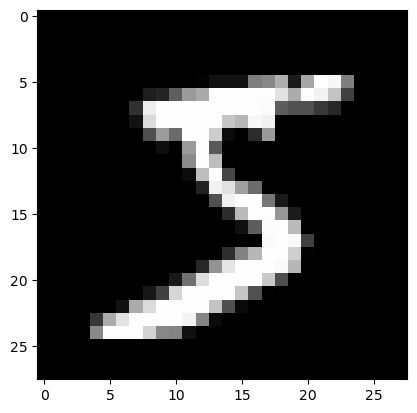

In [64]:
img = mnist_train.data[0]
plt.imshow(img, cmap='gray')

In [60]:
X = mnist_train.data.view((-1, 28**2)) / 255.0 # 정규화, matrix to vector
y = mnist_train.targets

In [74]:
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

* ```drop_last```: 마지막 배치는 다른 미니 배치보다 개수가 적을 수 있음. 이 미니 배치를 버릴지 결정

##### iii) 다층 퍼셉트론 설계 및 학습

784(28x28)개의 입력 뉴런, 10개의 출력 뉴런(0~9)을 가지는 다층 퍼셉트론을 구성

In [70]:
import torch.nn as nn
import torch.optim as optim

In [71]:
model = nn.Sequential(
    nn.Linear(28**2, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)


In [72]:
# 오차함수 선택
loss_fn = nn.CrossEntropyLoss().to(device) # 내부적으로 softmax 포함

# 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [73]:
# hyperparameters
num_epochs = 3

for epoch in range(num_epochs):
    for data, targets in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(data.to(device))
        loss = loss_fn(y_pred, targets.to(device))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/3, Loss: 0.2868
Epoch 2/3, Loss: 0.2206
Epoch 3/3, Loss: 0.2476


##### iv) 테스트 데이터에 대해 평가

In [85]:
mnist_test = datasets.MNIST(root="Data",
                           train=False,
                           transform=transforms.ToTensor(),
                           download=True)

X_test = mnist_test.data.view((-1, 28**2)) / 255.0
y_test = mnist_test.targets

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [92]:
model.eval()    # 신경망을 추론 모드로 전환

correct = 0

# 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
with torch.no_grad():  # 추론 과정에는 미분이 필요없음
    for data, targets in test_dataloader:
        outputs = model(data.to(device))  # 데이터를 입력하고 출력을 계산 (128x10)

        # 추론 계산
        _, predicted = torch.max(outputs, dim=1)  # 확률이 가장 높은 레이블이 무엇인지 계산 (argmax)
        correct += (predicted == targets.to(device).view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

# 정확도 출력
data_num = len(test_dataloader.dataset)  # 데이터 총 건수
print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct, data_num, 100. * correct / data_num))


테스트 데이터에서 예측 정확도: 9651/10000 (97%)

